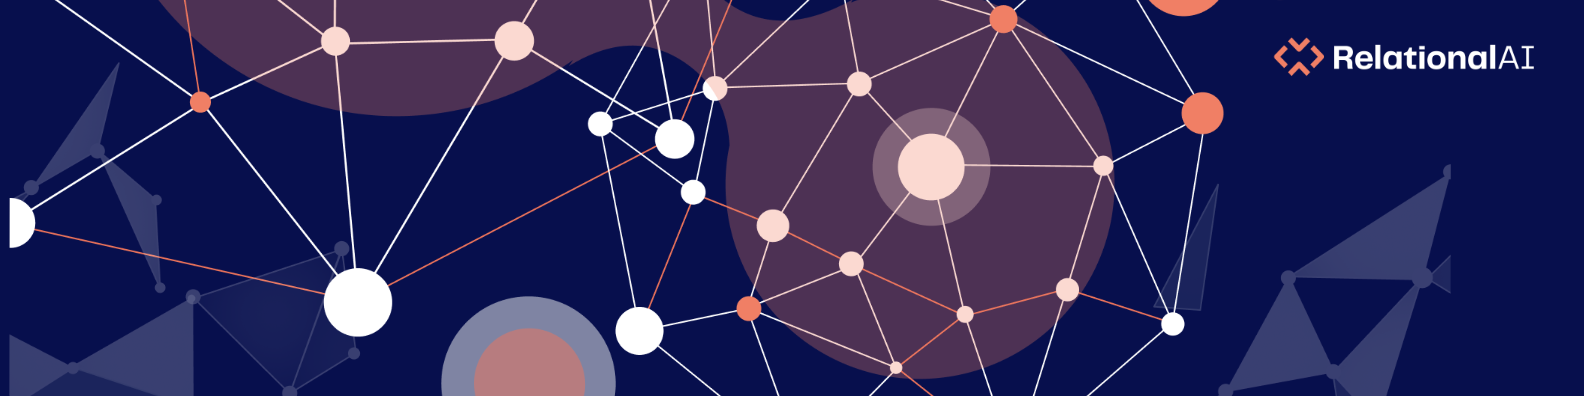

# RelationalAI Simple Start

## Overview
This notebook provides a minimalistic starting point to help you get up and running with RelationalAI.

To see examples that showcase RelationalAI's analytics capabilities, check out the other notebooks on the [docs site](https://relational.ai/docs/develop/example-notebooks/).

## What you will learn

- How to get RelationalAI's Python library running against your Snowflake data.
- How to run a simple graph algorithm over your data.

***

## Let's get started!

If you haven't already done so, begin by installing the RelationalAI Native App in your Snowflake account. See [this page in the RelationalAI documentation](https://relational.ai/docs/get-started/install-native-app) for instructions.

Next, [install RelationalAI's Python library into a local Python virtual environment](https://relational.ai/docs/get-started#install-the-relationalai-python-package) and run `rai init` to connect your project to your Snowflake account.

This notebook is written with the assumption that you're running it from such a virtual environment. To do that, navigate in your terminal to your project's root directory and run the following commands:

```bash
source .venv/bin/activate
python -m pip install jupyter
jupyter lab
```

*Note: The first command assumes you put your virtual environment in `.venv` as specified in the instructions in the documentation linked above. If you put it somewhere else, adjust the path accordingly.*

Next, perform the necessary imports:

In [1]:
import relationalai as rai
from relationalai.std import aggregates, alias
from relationalai.std.graphs import Graph

provider = rai.Provider()

The first time you run this notebook, you'll need to run the next two cells to create and populate a Snowflake table as well as setting up a data stream from this table to the RelationalAI app.

In [ ]:
provider.sql("""
begin
    create schema if not exists RAI_DEMO.SIMPLE_START;

    create or replace table RAI_DEMO.SIMPLE_START.CONNECTIONS (
        station_1 int,
        station_2 int
    );

    insert into RAI_DEMO.SIMPLE_START.CONNECTIONS (station_1, station_2) values
    (1, 2),
    (1, 3),
    (3, 4),
    (1, 4),
    (4, 5),
    (5, 7),
    (6, 7),
    (6, 8),
    (7, 8);
end;
""")

You can run the cell below if you want to verify that the insertion was successful:

In [ ]:
provider.sql("SELECT * FROM RAI_DEMO.SIMPLE_START.CONNECTIONS")

### Define Model in RelationalAI
Let's define our model object. **Models** represent collections of objects. **Objects**, like Python objects, have **types** and **properties**, which we will define in a bit.

In [ ]:
model = rai.Model("SimpleStart", ensure_change_tracking=True)

*Note: The `ensure_change_tracking` flag is set to `True` to ensure that [change tracking](https://relational.ai/docs/manage/data/#change-tracking) is enabled for all Snowflake source tables and views consumed by the model. Alternatively, you may set this in your [RAI configuration](https://relational.ai/docs/develop/guides/configuration).*

### Referencing Snowflake Data
Due to RelationalAI's tight integration with Snowflake, we can refer to data that we are streaming to our RelationalAI schema by simply referring to the source:\
**\<my_database>.\<my_schema>.<my_table\>**.

The data for this example consists of a single table called `CONNECTIONS` whose columns are called `station_1` and `station_2`. These station values represent IDs of power stations, and a row in the table represents a connection (via transmission lines and substations) between two power stations.

Accordingly, we will introduce two *types* that represent the two kinds of objects in our model: `Station` and `Connection`.

In [3]:
Station = model.Type("Station")

Connection = model.Type(
    "Connection",
    source="RAI_DEMO.SIMPLE_START.CONNECTIONS"
)

### Simple Queries

We can run a query to count the number of connections as follows:

In [4]:
# Count number of rows in the connections table:
with model.query() as select:
    connection = Connection()
    num_records = aggregates.count(connection)
    result = select(num_records)

result

We haven't yet said what a `Station` is. We can do that using a **rule**. In this rule we will also define the `is_connected` property for stations:

In [5]:
with model.rule():
    connection = Connection()
    station_1 = Station.add(id=connection.station_1)
    station_2 = Station.add(id=connection.station_2)
    station_1.is_connected.extend([station_2])
    station_2.is_connected.extend([station_1])

Now we can ask for a list of all the stations IDs:

In [6]:
with model.query() as select:
    station = Station()
    result = select(station.id)

result

### Graph Analysis

The power stations and connections between them form a graph. We can model a graph in RelationalAI by wrapping the model in a `Graph` object and associating data with its `Node` and `Edge` properties.

In [7]:
graph = Graph(model, undirected = True)
graph.Node.extend(Station, label=Station.id)
graph.Edge.extend(Station.is_connected)

We can visualize the graph using the `visualize` method:

In [8]:
graph.visualize()

You can see from the figure that Stations 4, 5, and 7 are especially critical to this network because they provide the only connection between two larger components. It's important to be able to quantify and compute this kind of information because it would not be so visually apparent in a larger, real-world network.

We can do that using a graph analytics metric called **betweenness centrality**. This metric and others are available under the `graph.compute` namespace:

In [9]:
with model.query() as select:
    station = Station()
    centrality = graph.compute.betweenness_centrality(station)
    result = select(station.id, alias(centrality, "betweenness_centrality"))

result

As predicted, Stations 4, 5, and 7 have the highest betweenness centrality scores!

### Conclusion

The functionality demonstrated in this notebook barely scratches the surface of what's possible with RelationalAI. The [Example Notebooks page on the docs site](https://relational.ai/docs/develop/example-notebooks/) contains a variety of example notebooks, each of which explores a scenario and a set of analytics capabilities in greater depth.

Brought to you by [RelationalAI](https://relational.ai/) & Snowflake Native Applications!